# Introduccion
## Efectos de cuantización de coeficientes en filtros interpoladores para retardo fraccional

 En este estudio se pretende determinar el impacto de la cuantizacion de coeficientes en filtros interpoladores de retardo fraccional utilizados comunmente en Procesadores Digitales de Señales para compensaciones de skew o de fase optima de muestreo. El efecto a observar es analizado en la propiedad de retardo de grupo de los sistemas lineales invariantes en el tiempo. En esta se puede determinar que tan precisa es la operacion de retardo fraccional aplicado.

Para este analisis se utlizaran sistemas y señales de comunicaciones digitales. En cuanto a los sistemas, se analizara una implementacion de filtrado en el dominio de la frecuencia y otra implementacion de filtrado en el dominio del tiempo. En ambas se determinara el efecto de la cuantizacion en el retardo de grupo para interpolaciones que van desde un retardo de $[0-0.5]T_s$ donde $T_s$ es el tiempo de muestreo. Por otro lado se barre la cuantizacion de punto fijo de bits fraccionales $NB_F$ que corresponde en la notacion clasica de punto fijo $S(NB.NB_F)$. A continuacion se presentan ambos metodos con señales de ejemplos. Ambos metodos intentan realizar un cambio de fase ideal que en frecuencia esta dado por 
$$ H_{id}(e^{j\omega})=e^{-j\omega D},D=I+d$$ donde $d$ representa el retraso fraccional.

# Desarrollo
## Presentacion de Filtros
### Interpolador Retardo Fraccional en Dominio de la Frecuencia

En la publicacion _"Closed Form Variable Fractional Time Delay Using FFT" (Soo Chong-Pei)_ se presenta una respuesta en frecuencia para realizar retardos fraccionales en dominio de frecuencia tal que $Y(z)=H(z)X(z)$.

Los coeficientes $H[k]$ para $H(z)$ estan dados por:

$H[k]=\begin{cases} 1, & k=0\\ e^{-jD(2\pi /N)k}, & k=1,2,...,\frac{N}{2}-1\\ cos(D\pi),& k=\frac{N}{2}\\ e^{jD(2\pi /N)N-k}, & k=\frac{N}{2}+1,...,N-1 \end{cases}$

A continuacion se mostrara un ejemplo de una señal y su retraso ideal (cambiando la fase de muestreo). Luego se aplicara el retraso fraccional a la señal original con el filtro y se comparara con la retrasada ideal.
#### Desarrollo

In [156]:
%matplotlib inline
import scipy.signal as sp
import matplotlib
import matplotlib.pyplot as pl
import numpy as np
import itertools
from commpy.filters import rrcosfilter
import math
import random

Se genera una señal banda base de comunicaciones con un filtro de rolloff=0.17 y muestreo $T_s=T_{B} \frac{5}{3}$ donde $T_B$ es el tiempo entre simbolos. Se muestra la **PSD** y una comparacion entre una señal y su version retrasada ideal $\delta=\frac{7}{16}=0.4375T_s$

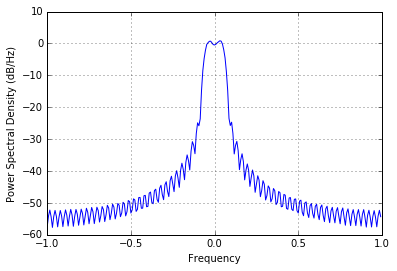

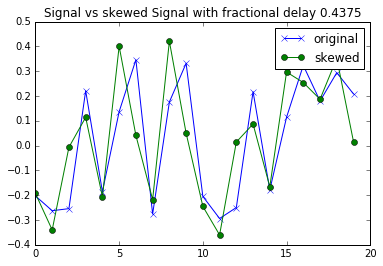

In [158]:
N_data = int(8192)
BR=33e9
analog_rate=16*BR
fix_adc_rate=5/3*BR
import random
N_data = int(10*1024)

def gen_data_rx(alfa=0.1):
    data = np.array([complex(2*random.randint(0,1)-1,2*random.randint(0,1)-1)
                     for i in xrange(N_data)])
    data_zeros = np.zeros((N_data*16,1),dtype=complex).flatten()
    data_zeros[1::16] = data    
    rcos_filter = rrcosfilter(64,alfa,1/BR,16*BR)[1]
    power_of_filter = np.sqrt(np.sum([ np.square(j) 
                                      for j in rcos_filter]))
    rcos_filter = rcos_filter/power_of_filter
    data_interp = np.convolve(rcos_filter, data_zeros,'same')
    return data_interp

Signal = gen_data_rx(0.17)
pl.psd(Signal)
pl.show()
from fractions import Fraction
a=Fraction(fix_adc_rate/analog_rate)
N_proc=512
sk_in_samples=7
def sample_data():
    sampled_data=sp.resample(Signal[:N_proc*8],int(N_proc*8*a))
    skewed_data=sp.resample(Signal[sk_in_samples:N_proc*8+sk_in_samples],
                            int(N_proc*8*a))
    return (sampled_data,skewed_data)

(sampled_data,skewed_data) = sample_data()
pl.plot(np.real(sampled_data[-20:]),'-x',label='original')
pl.plot(np.real(skewed_data[-20:]),'o-',label='skewed')
pl.title('Signal vs skewed Signal with fractional delay {0}'.format(sk_in_samples/16.0))
pl.legend()
pl.show()

Se implementa el filtro en dominio de la frecuencia ($N_{\text{FFT}=16}$) y se aplica el retraso fraccional.

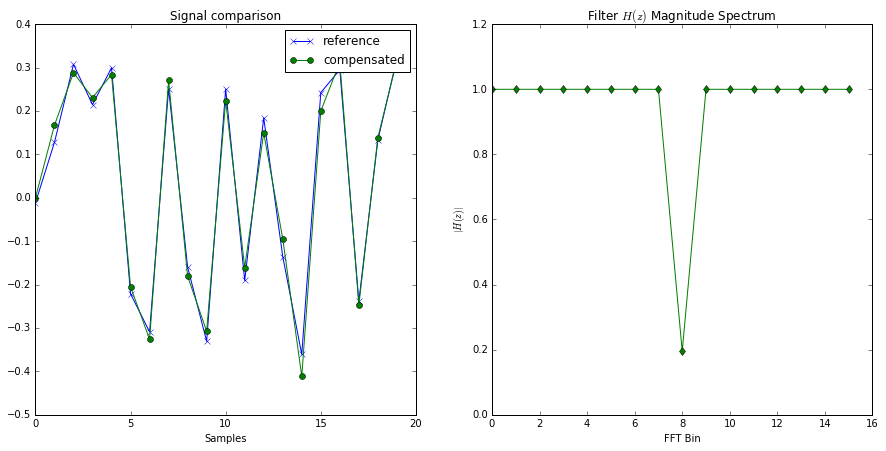

In [215]:
def fd_compensation(sk_in_samples=7,fft_size=16):
    

    D=1.0*sk_in_samples/16
    
    y=np.zeros((1,1))
    phases_pos = [np.exp(np.complex(0,-i*(D)*2*np.pi/fft_size)) 
                  for i in range(1,fft_size/2)]
    phases_neg = [np.exp(np.complex(0,(fft_size-i)*(D)*2*np.pi/fft_size))
                  for i in range(fft_size/2+1,fft_size)]
    phases_pos = np.append(1,phases_pos)
    phases_neg = np.append(np.real(np.exp(np.complex(0,-(D)*np.pi))),
                           phases_neg)
    phases= np.append(phases_pos,phases_neg)
    for i in range(N_proc/fft_size):
        regress=fft_size-2
        x=skewed_data[i*(regress):(i*regress)+fft_size]
        f=np.fft.fft(x,fft_size)
        g=np.array([f[i]*phases[i] for i in range(fft_size)])
        y=np.append(y,np.fft.ifft(g,fft_size)[1:-1])
    return (x,y,f,g,phases)
fft_size=16
(x,y,f,g,phases)=fd_compensation()
pl.figure(figsize=(15,7))
pl.title('FD Results')
pl.subplot(1,2,1)
pl.title('Signal comparison')
pl.plot(np.imag(sampled_data[:20]),'-x',label='reference')
pl.plot(np.imag(y[:20]),'-o',label='compensated')
pl.xlabel("Samples")
pl.legend()
pl.subplot(1,2,2)
pl.title('Filter $H(z)$ Magnitude Spectrum')
pl.plot(np.abs((phases)),'g-d')
pl.ylim([0,1.2])
pl.ylabel("$|H(z)|$")
pl.xlabel("FFT Bin")

pl.show()


Se grafica el "_group delay_" de este **SLIT** con la formula $\tau_g = - \frac{d\angle{H(e^{j\omega})}}{d\omega}$

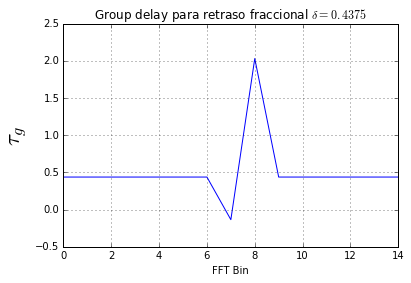

In [216]:
w=np.fft.fftfreq(fft_size, d=1.)
g_d=-1*(np.diff(np.unwrap(np.pi*np.angle(phases))/np.pi) / np.diff(2*np.pi*w))
#pl.figure(figsize=[15,10])
pl.plot(g_d)
pl.grid()
pl.title("Group delay para retraso fraccional $\delta=0.4375$")
pl.ylabel("$\\tau_g$",fontsize= 23)
pl.xlabel("FFT Bin")
pl.show()


### Interpolador Retardo Fraccional en Dominio del Tiempo

Para este interpolador se utiliza un filtro **FIR** de 6 taps con coeficientes de Lagrange representados por la formula:
$$h(n)=\sum _{k=0,k\neq n}^{N}{\frac{D-N}{n-k}}\text{    for }n=0,1,2...,N$$
Se muestra un ejemplo similar al filtro en el dominio de la frecuencia

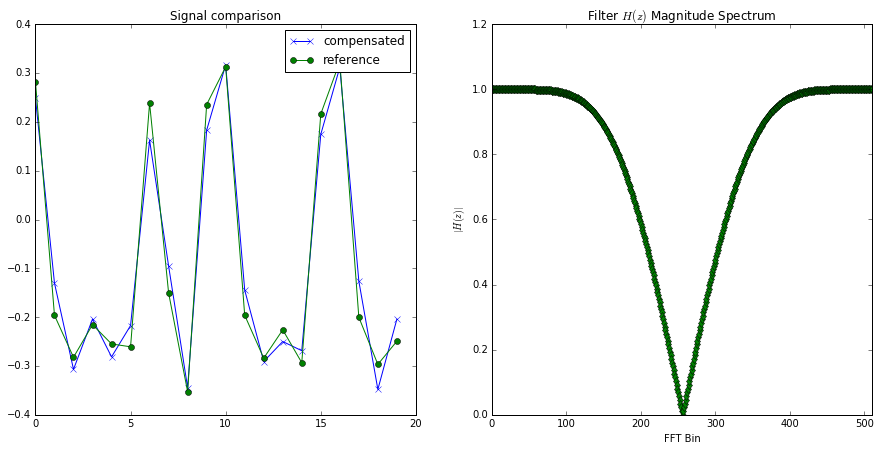

In [264]:
def td_compensation(sk_in_samples=8):
    n_index=64
    n_taps=6                 
    d = sk_in_samples/16.;
    D = d+2;
    x=skewed_data
    taps=[]
    for j in range(n_taps):     # // Taps Generation
        c_double = 1.0
        for k in range(n_taps): #// Products Generation
            if (k!=j):
              c_double = c_double * ((D-k)/(j-k))
        taps.append(c_double)
    taps.reverse()
    y = [  sum(taps*x[i:i+n_taps]) for i in range(len(x)-n_taps)]
    
    return y,taps
z,taps=td_compensation()
pl.figure(figsize=[15,7])
pl.title('TD Results')
pl.subplot(1,2,1)
pl.title('Signal comparison')
pl.plot(z[40:60],'-x',label='compensated')
pl.plot(sampled_data[43:63],'-o',label='reference')
pl.legend()
pl.subplot(1,2,2)
pl.title('Coefficients Spectrum')
pl.plot(np.abs(np.fft.fft(taps,512)),'g-d')
pl.title('Filter $H(z)$ Magnitude Spectrum')
pl.ylim([0,1.2])
pl.xlim([0,511])
pl.ylabel("$|H(z)|$")
pl.xlabel("FFT Bin")


pl.legend()
pl.show()

Se grafica el "_group delay_" de este **SLIT** con la formula $\tau_g = - \frac{d\angle{H(e^{j\omega})}}{d\omega}$ usando metodo de Scipy. Se quita la latencia default del filtro **FIR**$\lfloor{N_{TAPS}-1\over2}\rfloor$

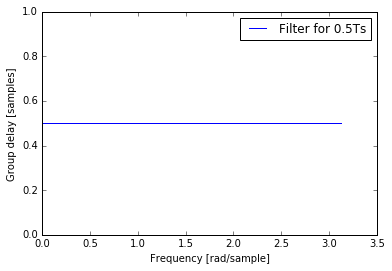

In [265]:
w, gd_pure = scipy.signal.group_delay(system=(taps,1))
limit=-1
pl.plot(w[:limit], 3-gd_pure[:limit],label="Filter for "
        +str(sk_in_samples/16.)+"Ts")
pl.ylabel('Group delay [samples]')
pl.ylim([0,1])
pl.xlabel('Frequency [rad/sample]')
pl.legend()
pl.show()

## Efectos de cuantizacion de coeficientes en retardo de grupo


Al cuantizar con redondeo estamos agregando un ruido al sistema igual a un proceso aleatorio de media cero y varianza $\sigma_e^2={2^{-2B}\over 12}$. Por la propiedad de los sistemas SLITs se puede predecir que el retardo de grupo del filtro cuantizado sera igual al ideal mas el retardo de grupo que origine el ruido de los coeficientes.
$$\hat{H}(z)=H(z)+\Delta H(z)$$
$$\tau_g(\hat{H}(z))=\tau_g(H(z))+\tau_g(\Delta H(z))$$
Siendo $\Delta H(z)$ el sistema lineal correspondiente a coeficientes representados aleatoriamente por ruido de cuantizacion.

### Interpolador Retardo Fraccional en Dominio de la Frecuencia
En el caso del dominio de la frecuencia,  $\Delta H(z)\neq Q(H(z))$, siendo $Q(.)$ la funcion de cuantizacion de coeficientes.  Por lo que cuantizar en los coeficientes de filtro en el dominio de la frecuencia puede implicar efectos diferentes que son convienentes de simular. En este estudio se prueba:
 * Filtro en frecuencia de tamaño: 8,16
 * Resoluciones de bits en la parte fraccional: 6,7 
 * Retardo fraccional: 1/16 a 0.5 $T_s$ (8 pasos)
 
Se mide el error respecto al filtro sin cuantizar y se calcula la media y el error maximo entre todos los retardos de ese filtro.

Analisis para Filtro de tamaño 16 y 6 bits fraccionales


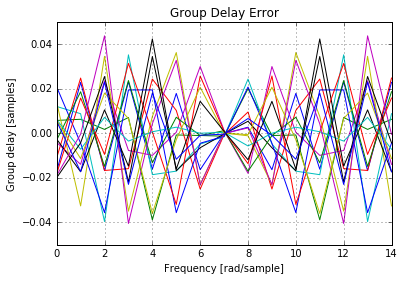

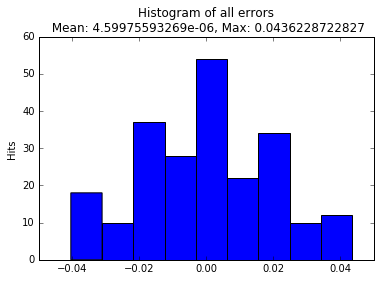

In [312]:
collect_fd={}
from deModel import DeFixedInt
def analyze_fd_delay_group(n=16,nbf=6,plot=True):
        
    fft_size=n
    history=[]
    w=np.fft.fftfreq(fft_size, d=1.)
    for m in range(1,16):
        sk_in_samples=m
        (x,y,f,g,phases)=fd_compensation(m,n)
        fd_taps_quantized=[np.complex(DeFixedInt(12,nbf,float(np.real(i))).fValue,
                                      DeFixedInt(12,nbf,float(np.imag(i))).fValue) 
                                       for i in phases]
        g_d=-1*(np.diff(np.unwrap(np.pi*np.angle(phases))/np.pi) / np.diff(2*np.pi*w))
        g_d_q=-1*(np.diff(np.unwrap(np.pi*np.angle(fd_taps_quantized))/np.pi) / np.diff(2*np.pi*w))
        #pl.plot(np.diff(np.angle(phases))-np.diff(np.angle(fd_taps_quantized)))
        freqs=w[:-1]
        error=g_d-g_d_q
        history.extend(error)
        if (plot):
            pl.title('Group Delay Error')
            pl.plot(error)

    if (plot):
        print ("Analisis para Filtro de tamaño "
            +str(n)+" y "+str(nbf)+" bits fraccionales")
    
        pl.ylabel('Group delay [samples]')
        pl.xlabel('Frequency [rad/sample]')
        pl.grid()
        pl.legend()
        pl.figure()
        pl.hist(history,bins=9)
        pl.ylabel('Hits')
        pl.title('Histogram of all errors\n Mean: '+str(np.mean(history))+', Max: '+str(np.max(history)))
        pl.show()


    if (n in collect_fd):
        collect_fd[n].update({nbf:np.max(history)})
    else:
        collect_fd[n]={nbf:np.max(history)}



analyze_fd_delay_group()


Analisis para Filtro de tamaño 16 y 7 bits fraccionales


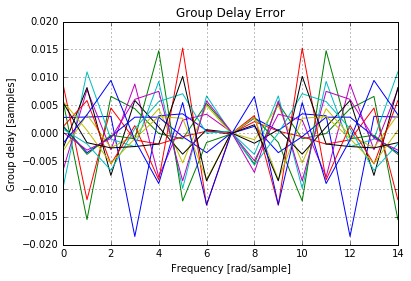

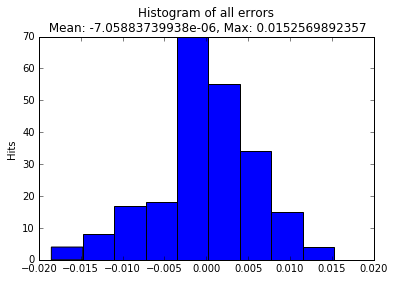

In [313]:
analyze_fd_delay_group(16,7)

\newpage

Analisis para Filtro de tamaño 8 y 6 bits fraccionales


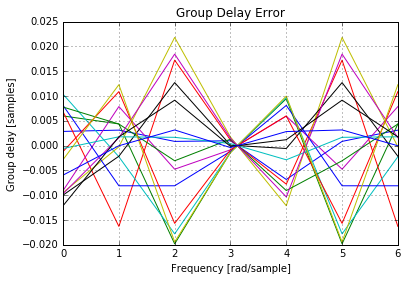

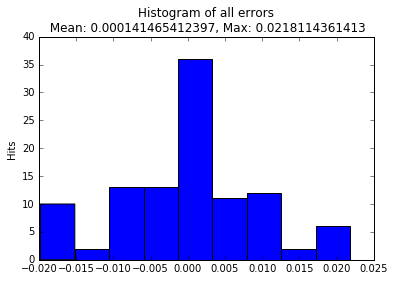

In [314]:
fft_samples=8
analyze_fd_delay_group(8,6)

Analisis para Filtro de tamaño 8 y 7 bits fraccionales


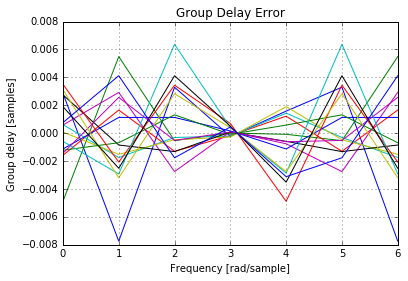

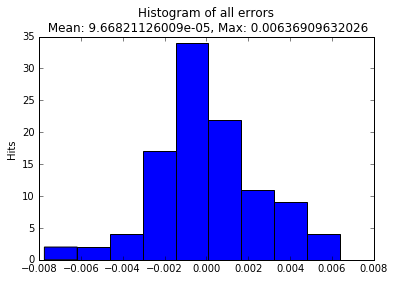

In [315]:
analyze_fd_delay_group(8,7)

En filtros en el dominio de la frecuencia la cuantizacion del coeficiente afecta el error de group delay de una manera directa y en funcion del tamaño del filtro. Cuando se representa con mas puntos mas precisa debe ser la cuantizacion, pero al mismo tiempo permite obtener mas muestras en paralelo. Aumentar 1 bit redujo la potencia por un factor de 3 en ambos tamaños de filtros.

### Interpolador Retardo Fraccional en Dominio de la Frecuencia



Analisis para Filtro 6 bits fraccionales


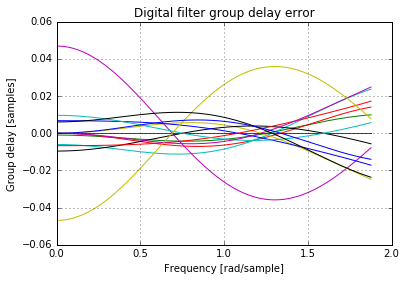

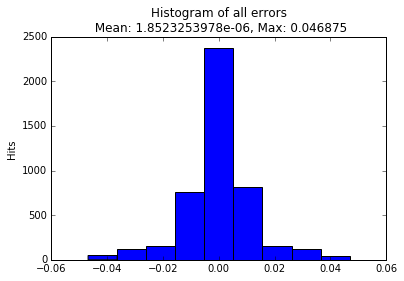

Analisis para Filtro 7 bits fraccionales


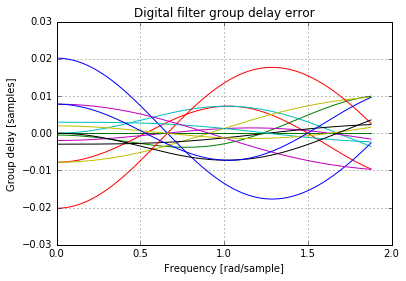

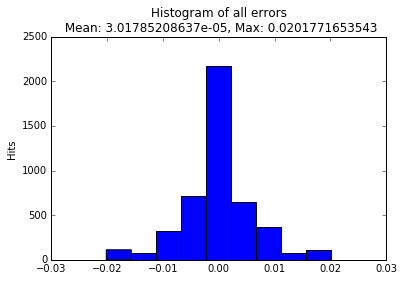

Analisis para Filtro 8 bits fraccionales


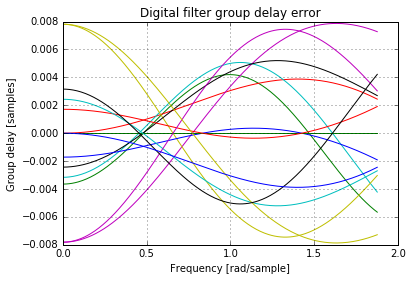

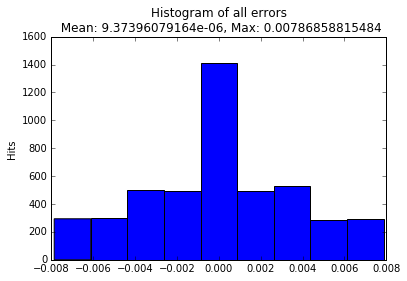

Analisis para Filtro 9 bits fraccionales


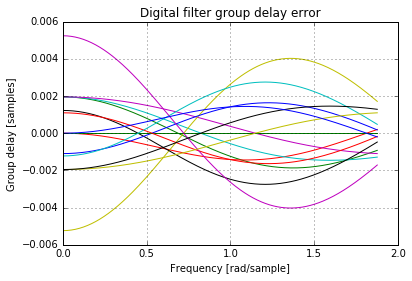

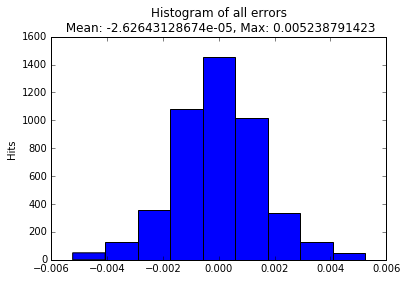

In [316]:
collect_td={}
def analyze_td_delay_group(nbf=5,plot=True):

    history=[]
    for m in range(15):
        sk_in_samples=m
        z,taps=td_compensation(m)
        taps_with_q_noise=[i+random.gauss(mu=0,sigma=2*np.sqrt(2.**(-2*nbf)/12)) for i in taps]
        taps_quantized=[DeFixedInt(2,nbf,i).fValue for i in taps]
        w, gd = scipy.signal.group_delay((taps_quantized,[1]))
        w, gd_pure = scipy.signal.group_delay((taps,[1]))
        limit=len(w)*3/5
        if plot:
            pl.title('Digital filter group delay error')
            
            pl.plot(w[:limit],gd[:limit]-gd_pure[:limit],label="Skew Filter "+str(sk_in_samples/16.)+" samples")
        history.extend(gd[:limit]-gd_pure[:limit])            
    collect_td.update({nbf:np.max(history)})
    if plot:
        print ("Analisis para Filtro "
                +str(nbf)+" bits fraccionales")
        pl.ylabel('Group delay [samples]')
        pl.xlabel('Frequency [rad/sample]')
        pl.grid()
        pl.figure()

        pl.hist(history,bins=9)
        pl.ylabel('Hits')
        pl.title('Histogram of all errors\n Mean: '+str(np.mean(history))+', Max: '+str(np.max(history)))
        pl.show()


for i in range(6,10):
    analyze_td_delay_group(i)

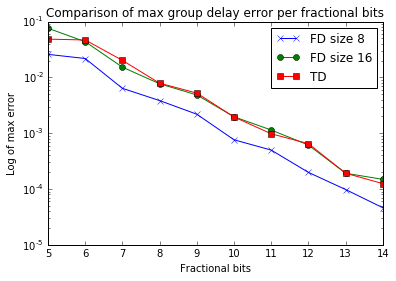

In [321]:
for i in range(5,15):
    analyze_fd_delay_group(8,i,False)
    analyze_fd_delay_group(16,i,False)
    analyze_td_delay_group(i,False)
    
pl.semilogy(collect_fd[8].keys(),collect_fd[8].values(),'x-',label='FD size 8')

pl.semilogy(collect_fd[16].keys(),collect_fd[16].values(),'o-',label='FD size 16')

pl.semilogy(collect_td.keys(),collect_td.values(),'s-',label='TD')
pl.title('Comparison of max group delay error per fractional bits')
pl.xlabel('Fractional bits')
pl.ylabel('Log of max error')
pl.legend()